In [1]:
from __future__ import annotations
from typing import Any
from dataclasses import dataclass
import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel


@register_dataclass
@dataclass
class Triplet(hodel.EnergyModel):
    """3 node spring where Theta is [K_1, K_2]"""

    l_k: jax.Array

    @classmethod
    def init(cls, xf0, xb0) -> Triplet:
        x0 = xb0[0]
        x1, x2 = xf0
        return cls(jnp.array([x1 - x0, x2 - x1]))

    @staticmethod
    def get_strain(x0, x1, x2, l_k) -> jax.Array:
        return jnp.array([x1 - x0, x2 - x1]) / l_k

    def get_K(self, del_strain: jax.Array, Theta: jax.Array) -> jax.Array:
        return jnp.diag(jnp.abs(Theta))

    def get_energy(
        self,
        xf: jax.Array,
        xb: jax.Array = jnp.array([]),
        Theta: jax.Array = jnp.array([]),
        aux=None,
    ) -> jax.Array:
        # xb = [x0], xf = [x1, x2]
        x0 = xb[0]
        x1, x2 = xf
        del_strain = self.get_strain(x0, x1, x2, self.l_k) - 1.0
        return 0.5 * del_strain @ self.get_K(del_strain, Theta) @ del_strain


@register_dataclass
@dataclass
class LinearForce(hodel.ExternalForce):
    """Linear force with offset"""

    f: jax.Array
    c: jax.Array

    def get_grad_energy(self, lambda_: jax.Array, aux: Any = None) -> jax.Array:
        return lambda_ * self.f + self.c


def fixed_0(lambda_: jax.Array, _=None) -> jax.Array:
    return jnp.array([0.0])


# Setup
# force is setup to mimic gravity + lambd varying load
# assume total spring weighs 0.03 kg and each node has equal contribution
xf0 = jnp.array([1.0, 2.0])
energy = Triplet.init(xf0, fixed_0(jnp.array([0.0])))
force = LinearForce(jnp.array([0.0, 20.0]), jnp.array([9.81 * 1e-2, 9.81 * 1e-2]))
sim = hodel.HODEL(energy, [force], fixed_0)

key = jax.random.PRNGKey(0)
Theta_star = jnp.array([5.0, 2.0])
lambdas = jnp.linspace(0, 1, 10)

print("λ=0: ", sim.solve(jnp.array([0.0]), xf0, Theta_star))
print("λ=1: ", sim.solve(jnp.array([1.0]), xf0, Theta_star))

λ=0:  [1.03924 2.08829]
λ=1:  [ 5.0392404 16.08829  ]


In [ ]:
import diffrax

sol = diffrax.diffeqsolve(
    sim.get_ode_term(Theta_star),
    diffrax.Dopri5(),
    t0=0.0,
    t1=1.0,
    dt0=1e-3,
    y0=jnp.array([1.03924, 2.08829]),
    saveat=diffrax.SaveAt(ts=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
)
sol.ys

Array([[ 1.03924  ,  2.08829  ],
       [ 1.4392391,  3.4882798],
       [ 1.8392451,  4.888275 ],
       [ 2.2392468,  6.2882767],
       [ 2.639247 ,  7.688288 ],
       [ 3.039247 ,  9.0883   ],
       [ 3.439247 , 10.488312 ],
       [ 3.8392467, 11.888324 ],
       [ 4.239233 , 13.288336 ],
       [ 4.6392093, 14.688347 ],
       [ 5.0391855, 16.088358 ]], dtype=float32)

In [ ]:
xf_stars = sim.sim(lambdas, xf0, Theta_star)
Theta0 = jax.random.uniform(key, [2], minval=1e-1, maxval=1e1)
lr = 2e-1
nepochs = 100

final_Theta, L = sim.learn(
    lambdas, xf0, xf_stars, Theta0, optim=optax.adam(lr), nepochs=nepochs
)

print("True Theta:", Theta_star)
print("Theta0:", Theta0)
print("Final Theta:", final_Theta)

True Theta: [5. 2.]
Theta0: [9.481903 9.787941]
Final Theta: [5.1493526 1.9660006]


In [5]:
import flax.linen as nn


@register_dataclass
@dataclass
class KSTriplet(Triplet):
    def get_K(self, del_strain, Theta):
        # Theta = [K0_1, alpha_1, K0_2, alpha_2]
        K0_1, alpha_1, K0_2, alpha_2 = Theta
        K1 = K0_1 * jnp.exp(alpha_1 * del_strain[0])
        K2 = K0_2 * jnp.exp(alpha_2 * del_strain[1])
        return jnp.diag(jnp.array([K1, K2]))


Theta_star = jnp.array([5.0, 0.4, 2.0, 0.8])
ks_energy = KSTriplet.init(xf0, fixed_0(jnp.array([0.0])))
ks_sim = hodel.HODEL(ks_energy, (force,), fixed_0)


class KNet(nn.Module):
    """Simple 2 x 2 PSD module"""

    hidden_size: int

    @nn.compact
    def __call__(self, del_strain):
        x = nn.softplus(
            nn.Dense(
                self.hidden_size,
            )(del_strain)
        )
        x = nn.softplus(
            nn.Dense(
                self.hidden_size,
            )(x)
        )
        # Initialize bias to K=4 to make first executions reasonable.
        # Kernel to 0 is just experimental. It makes the first run strictly DER.
        x = nn.Dense(
            2,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.constant(4.0),
        )(x)
        a, b = x
        a = jax.nn.softplus(a)
        b = jax.nn.softplus(b)
        return jnp.array([[a, 0.0], [0.0, b]])

    @nn.compact
    def psd(self, del_strain):
        # Unused, off diagonals were messing things up but with proper init it should probably work
        x = nn.tanh(nn.Dense(self.hidden_size)(del_strain))
        x = nn.Dense(3)(x)
        a, b, c = x
        a = jax.nn.softplus(a)
        c = jax.nn.softplus(c)
        L = jnp.array([[a, 0.0], [b, c]])
        return L @ L.T

model = KNet(10)

@register_dataclass
@dataclass
class NNTriplet(Triplet):
    """3 node spring where Theta is parameters for a neural network."""

    def get_K(self, del_strain: jax.Array, Theta: Any) -> jax.Array:
        return model.apply(Theta, del_strain)  # type: ignore


# TODO: Figure out how to make this more seamless

params = model.init(key, jnp.zeros(2))
nn_energy = NNTriplet.init(xf0, fixed_0(jnp.array([0.0])))
nn_sim = hodel.HODEL(nn_energy, (force,), fixed_0)

print(
    "λ=0: ",
    nn_sim.solve(jnp.array([0.0]), xf0, params),
    ks_sim.solve(jnp.array([0.0]), xf0, Theta_star),
)
print(
    "λ=1: ",
    nn_sim.solve(jnp.array([1.0]), xf0, params),
    ks_sim.solve(jnp.array([1.0]), xf0, Theta_star),
)

λ=0:  [1.0488285 2.0732427] [1.0383486 2.08475  ]
λ=1:  [ 6.026244 12.028073] [2.6071668 5.244973 ]


truth:  [[1.0383486 2.08475  ]
 [1.3850032 2.972279 ]
 [1.6377859 3.4922714]
 [1.8398569 3.879624 ]
 [2.0095243 4.19291  ]
 [2.15646   4.4578323]
 [2.286459  4.6883187]
 [2.4032934 4.8928757]
 [2.5095692 5.07712  ]
 [2.6071668 5.244973 ]]
nn:  [[1.0333133 2.0643713]
 [1.3835373 2.960748 ]
 [1.6436682 3.512788 ]
 [1.8419679 3.890333 ]
 [2.0067728 4.188703 ]
 [2.1509764 4.444209 ]
 [2.2809758 4.6729064]
 [2.40038   4.883106 ]
 [2.5114443 5.0796585]
 [2.6156917 5.26565  ]]


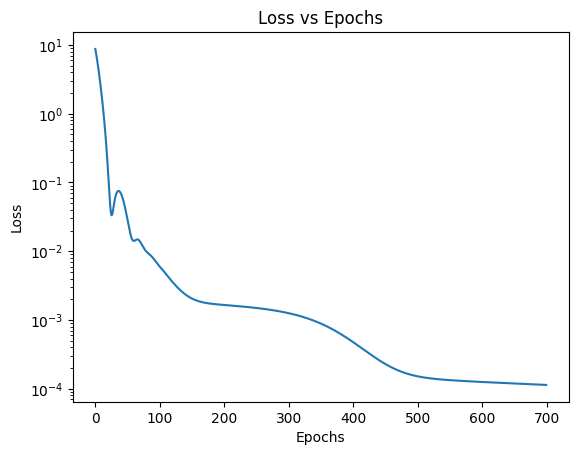

In [6]:
xf_stars = ks_sim.sim(lambdas, xf0, Theta_star)

lr = 1e-2
nepochs = 700
# schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=n_epochs, alpha=0.2)

final_params, L = nn_sim.learn(lambdas, xf0, xf_stars, params, optim=optax.adam(lr), nepochs=nepochs)
final_xfs = nn_sim.sim(lambdas, xf0, final_params)

print("truth: ", xf_stars)
print("nn: ", final_xfs)

plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

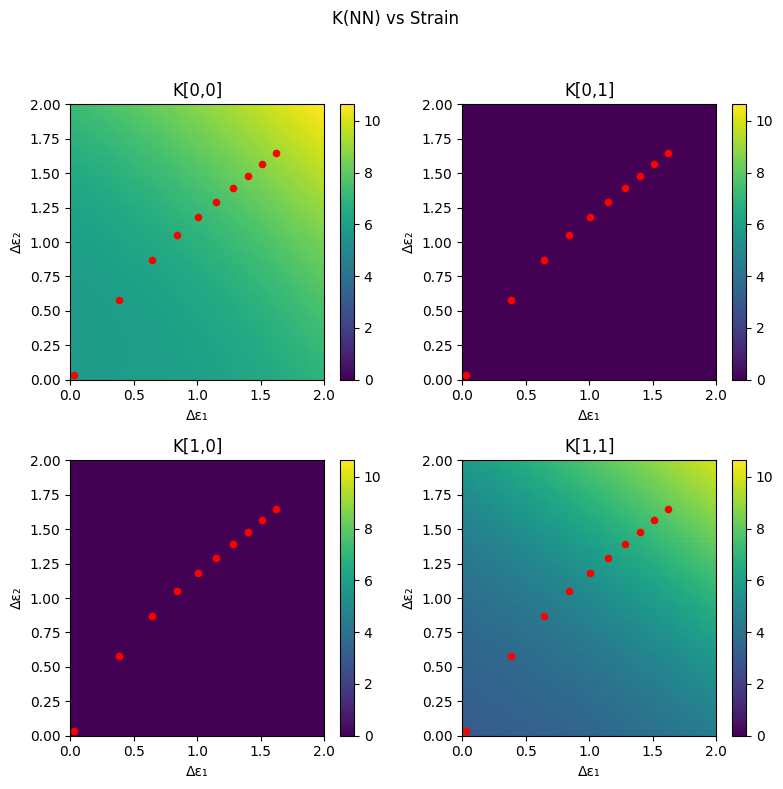

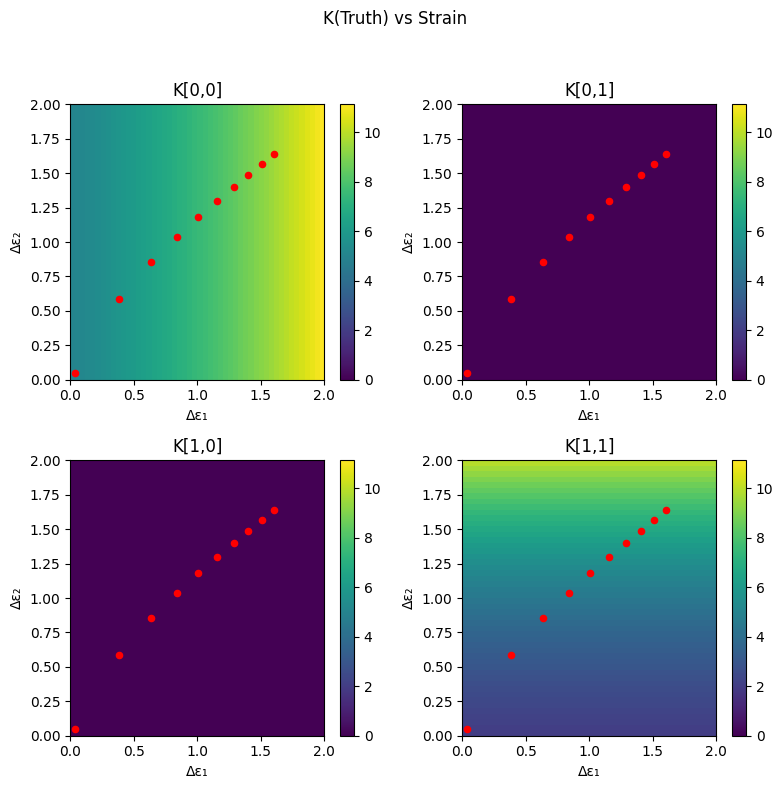

In [7]:
# Range of del_strains
del_strains = []
for x1, x2 in final_xfs:
    del_strains.append(nn_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
del_strains = jnp.stack(del_strains)

ks_del_strains = []
for x1, x2 in xf_stars:
    ks_del_strains.append(ks_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
ks_del_strains = jnp.stack(ks_del_strains)

# Get grid for heatmap
eps1_min, eps2_min = del_strains.min(0)
eps1_max, eps2_max = del_strains.max(0)
eps1 = jnp.linspace(jnp.floor(eps1_min), jnp.ceil(eps1_max), 50)
eps2 = jnp.linspace(jnp.floor(eps2_min), jnp.ceil(eps2_max), 50)
E1, E2 = jnp.meshgrid(eps1, eps2)
del_strains_map = jnp.stack([E1.ravel(), E2.ravel()], axis=-1)

# Generate map of Ks
nn_K = jax.vmap(lambda s: nn_energy.get_K(s, final_params))(del_strains_map)
ks_K = jax.vmap(lambda s: ks_energy.get_K(s, Theta_star))(del_strains_map)


def visualize_K(K, del_strains, suptitle="K vs Strains"):
    K11 = K[:, 0, 0].reshape(E1.shape)
    K12 = K[:, 0, 1].reshape(E1.shape)
    K21 = K[:, 1, 0].reshape(E1.shape)
    K22 = K[:, 1, 1].reshape(E1.shape)

    Ks = [K11, K12, K21, K22]
    titles = ["K[0,0]", "K[0,1]", "K[1,0]", "K[1,1]"]

    vmin = min(np.min(Kij) for Kij in Ks)
    vmax = max(np.max(Kij) for Kij in Ks)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()

    for ax, Kij, title in zip(axs, Ks, titles):
        im = ax.imshow(
            np.asarray(Kij),
            extent=(eps1.min(), eps1.max(), eps2.min(), eps2.max()),
            origin="lower",
            cmap="viridis",
            aspect="auto",
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlabel("Δε₁")
        ax.set_ylabel("Δε₂")
        ax.scatter(
            del_strains[:, 0],
            del_strains[:, 1],
            color="red",
            s=20,
            marker="o",
            label="Equilibria",
        )
        ax.set_title(title)
        fig.colorbar(im, ax=ax)

    fig.suptitle(suptitle)
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # keep suptitle visible
    # fig.savefig(f"{suptitle}.png", dpi=300, bbox_inches='tight')
    plt.show()


visualize_K(nn_K, del_strains, "K(NN) vs Strain")
visualize_K(ks_K, ks_del_strains, "K(Truth) vs Strain")

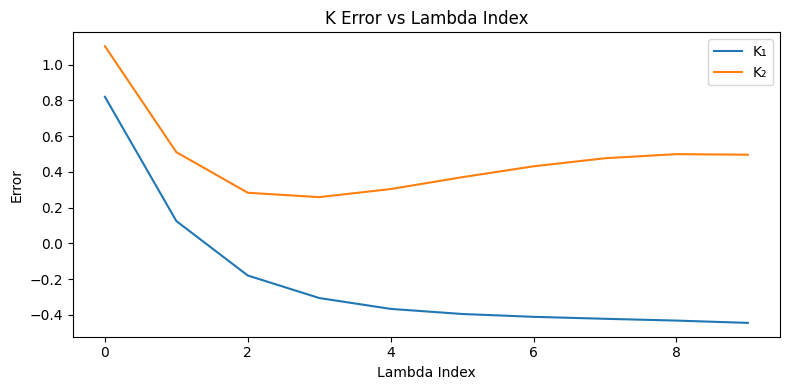

In [8]:
def visualize_K_diff(nn: Triplet, truth: Triplet, del_strains) -> None:
    error = jax.vmap(lambda s: nn.get_K(s, final_params) - truth.get_K(s, Theta_star))(
        del_strains
    )
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(error[:, 0, 0], label="K₁")
    ax.plot(error[:, 1, 1], label="K₂")
    ax.legend()
    ax.set_title("K Error vs Lambda Index")
    ax.set_ylabel("Error")
    ax.set_xlabel("Lambda Index")
    fig.tight_layout()
    # fig.savefig("test.png", dpi=300, bbox_inches='tight')
    plt.show()


visualize_K_diff(nn_energy, ks_energy, del_strains)